Mounting Google Drive storage

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


Setting up our environment to use Keras 2.1.5 and Tensorflow 1.x as Keras's backend

In [ ]:
%tensorflow_version 1.x
!pip install keras==2.1.5

import os

# Providing our environment with Kaggle's API key so we can access datasets
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Datasets/tp2_mask

/content/gdrive/My Drive/Datasets/tp2_mask


Downloading our dataset and extracting it

In [ ]:
# Dataset taken from:
# https://www.kaggle.com/andrewmvd/face-mask-detection?select=images

%%shell
kaggle datasets download -d andrewmvd/face-mask-detection
ls
unzip \*.zip
rm *.zip

Cloning Mask RCNN implementation to our gdrive

More info: https://arxiv.org/abs/1703.06870


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
%%shell

cd Mask_RCNN
ls
python setup.py install

assets	images	     mask_rcnn_coco.h5	 README.md	   setup.cfg
build	LICENSE      mask_rcnn.egg-info  requirements.txt  setup.py
dist	MANIFEST.in  mrcnn		 samples
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/e

Importing all the libs and tools we'll need


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize

import mrcnn

from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray

import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model

%matplotlib inline

from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


Creating our configuration class for Mask RCNN

In [ ]:
class myMaskRCNNConfig(Config):

  # give the config a recognizable name
  NAME = "MaskRCNN_config"

  # set the number of GPUs to use along with the number of images
  # per GPU

  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  # number of classes (adding +1 for background)
  # mask + nomask + worn_incorrectly + bg

  NUM_CLASSES = 3+1

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 80

  # Learning rate
  LEARNING_RATE = 0.006

  # Skip detections with < 85% confidence
  DETECTION_MIN_CONFIDENCE = 0.85

  # setting Max ground truth instances
  MAX_GT_INSTANCES = 10

  # setting the dataset path
  DATASET_PATH = "/content/gdrive/My Drive/Datasets/tp2_mask"

In [ ]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   /content/gdrive/My Drive/Datasets/tp2_mask
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'm

Creating a custom Dataset class

In [ ]:
# Our data is in the Pascal VOC data format
# More info:
# https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5

class MaskDataset(Dataset):

  # load the dataset definitions

  def load_dataset(self, dataset_dir, is_train=True):

    class_list = list()

    # define the location for images and annotations
    # dataset_dir concat may be done later
    # explicit path
    images_path = config.DATASET_PATH + '/images/'
    annotations_path = config.DATASET_PATH + '/annotations/'

    for filename in listdir(annotations_path):

      tree = ElementTree.parse(annotations_path + filename)

      root = tree.getroot()
      img_filename = root.find('.//filename').text

      for classname in root.findall('.//name'):
        class_list.append(classname.text)

      # each image will be identified by it's filename without the extension
      img_id = img_filename[:-4]

      if is_train and int(img_id[12:]) >= 600:
        continue
      if not is_train and int(img_id[12:]) < 600:
        continue
        
      # setting the path of the image file
      img_path = images_path + img_filename

      # setting the path of the annotations file
      ann_path = annotations_path + filename

      # adding the images and the annotations to the dataset
      self.add_image('dataset', image_id=img_id, path=img_path, annotation=ann_path)
    
    class_list = list(dict.fromkeys(class_list))
    i = 1

    for classname in class_list:
      self.add_class("dataset", i, classname)
      i=i+1

  def extract_boxes(self, filepath):

    tree = ElementTree.parse(filepath)
    root = tree.getroot()

    boxes = list()
    class_names = list()

    for obj in root.findall('.//object'):

      class_names.append(obj.find('name').text)

      for box in obj.findall('.//bndbox'):
      
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)

        coors = [xmin, ymin, xmax, ymax]

        boxes.append(coors)
    
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)

    return class_names, boxes, width, height
  
  def load_mask(self, image_id):

    # get the details of the image
    info = self.image_info[image_id]

    # define the annotation file location
    path = info['annotation']
    
    # load xml bounding boxes
    class_names, boxes, w, h = self.extract_boxes(path)

    # TODO check 
    # create one array for all masks, each on a different channel

    masks = zeros([h, w, len(boxes)], dtype='uint8')

    # create the masks
    class_ids = list()

    for i in range(len(boxes)):

      box = boxes[i]

      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]

      masks[row_s:row_e, col_s:col_e, i] = 1

      class_ids.append(self.class_names.index(class_names[i]))

    return masks, asarray(class_ids, dtype='int32')

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    print(info)
    return info['path']


Alright, now with that all out of the way, we'll now instantiate our datasets (train and test/validation) 

In [ ]:
# prepare the train set

train_set = MaskDataset()
train_set.load_dataset('', is_train=True)
train_set.prepare()

print('Train: %d' % len(train_set.image_ids))

# prepare the test/val set

test_set = MaskDataset()
test_set.load_dataset('', is_train=False)
test_set.prepare()

print('Test: %d' % len(test_set.image_ids))

Train: 600
Test: 253


Getting the pre-trained weights file to our drive

In [ ]:
%%shell

pwd
cd ./Mask_RCNN/
wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
cd ..

In [ ]:
print("Loading the model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

# loading the pre-trained coco weights
# load the weights for COCO
model.load_weights(config.DATASET_PATH + '/Mask_RCNN/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Loading the model...





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








Now let's begin the model's training!

In [ ]:
print("Model training will start in a few seconds...")
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=64, layers='heads')
history = model.keras_model.history.history

Our precious model has been generated and our weights adjusted... let's go ahead and save our model weights to a file

In [ ]:
model_path = './mask_rcnn_' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)
print(model_path)

It's prediction time... We'll go ahead and try to see if our model is classifying random images correctly... let's throw in a random image to see how it's doing



Instructions for updating:
Use `tf.cast` instead.


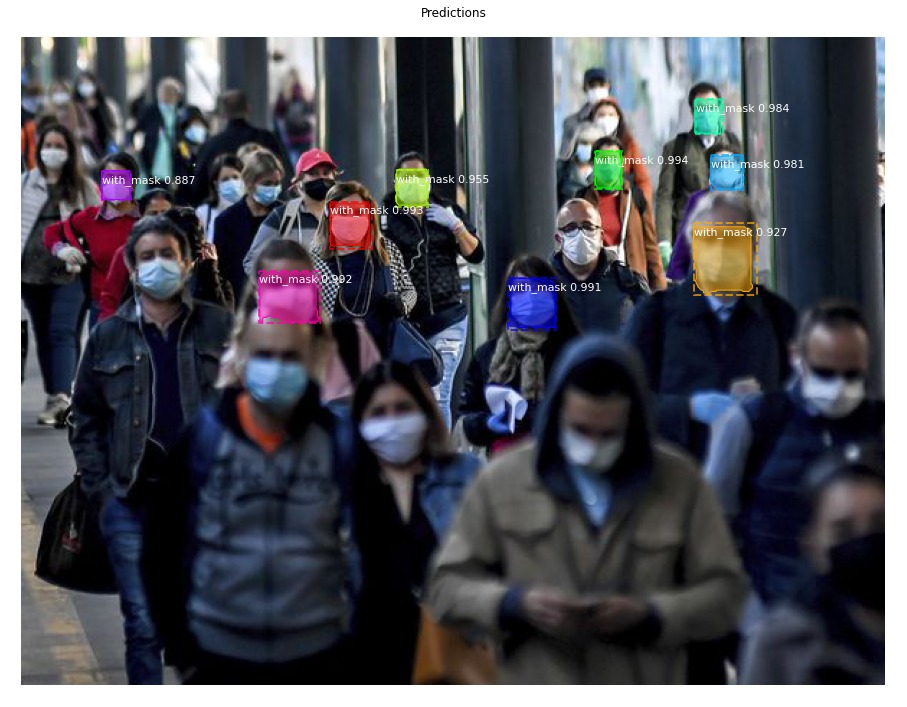

In [ ]:
model = modellib.MaskRCNN(mode='inference', model_dir='./', config=config)
model.load_weights('mask_rcnn_1591052810.3036718.h5', by_name=True)

filename = 'original_2.jpg'

img = load_img(filename)
img = img_to_array(img)

results = model.detect([img], verbose=0)

for r in results:

  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")